# Titanic dataset classification

## Setup

In [30]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Things/uni/jul/Julia-for-Optimization-and-Learning-Scripts/project_wrap/Titanic/examples`


In [31]:
using Titanic
using DataFrames
using Statistics
using StatsBase
using StatsPlots
using Flux
using Plots

In [32]:
gr()
theme(:lime)

In [50]:
df = read_csv_data("../data/train.csv")
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,PassengerId,446.0,1,446.0,891,0,Int64
2,Survived,0.383838,0,0.0,1,0,Int64
3,Pclass,2.30864,1,3.0,3,0,Int64
4,Name,,"Abbing, Mr. Anthony",,"van Melkebeke, Mr. Philemon",0,String
5,Sex,,female,,male,0,String7
6,Age,29.6991,0.42,28.0,80.0,177,"Union{Missing, Float64}"
7,SibSp,0.523008,0,0.0,8,0,Int64
8,Parch,0.381594,0,0.0,6,0,Int64
9,Ticket,,110152,,WE/P 5735,0,String31


## Data (pre-)processing

* target variable
    * survived
* ordinal properties(numerical)
    * pclass
    * age
    * sibsp
    * parch
    * fare
* nominal properties:
    * sex
    * name
    * ticket
    * cabin
    * embarked

### Couple of graphs

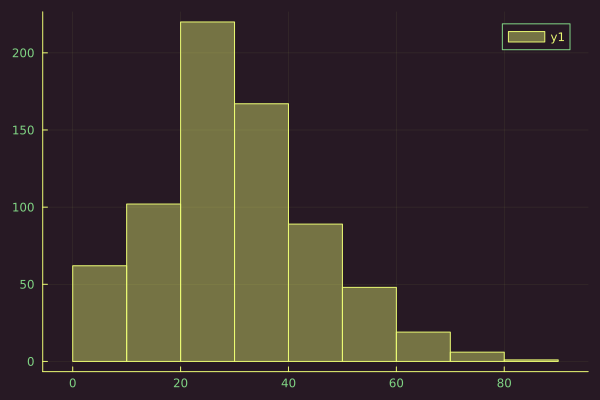

In [34]:
@df df histogram(:Age, bins = :scott, fillalpha = 0.4)

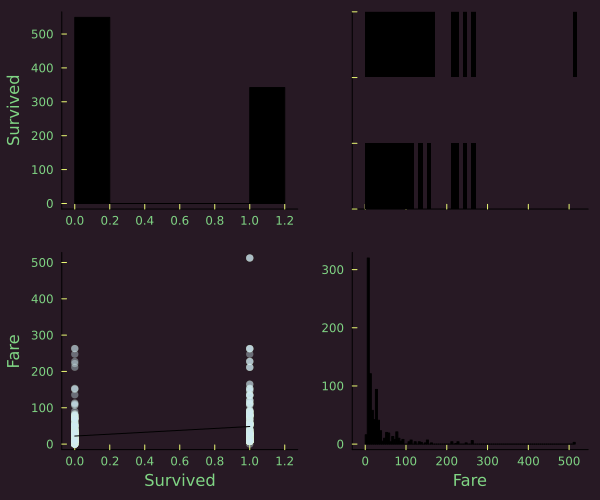

In [35]:
gr(size = (600, 500))
@df df corrplot([:Survived :Fare], grid = false)

### Missing values

how many values do we miss in each column?

In [36]:
Dict(map(col -> (col, (count(ismissing, df[!, col])/ nrow(df), count(ismissing, df[!, col]))), names(df)))

Dict{String, Tuple{Float64, Int64}} with 12 entries:
  "Pclass"      => (0.0, 0)
  "Ticket"      => (0.0, 0)
  "Age"         => (0.198653, 177)
  "SibSp"       => (0.0, 0)
  "PassengerId" => (0.0, 0)
  "Survived"    => (0.0, 0)
  "Cabin"       => (0.771044, 687)
  "Embarked"    => (0.00224467, 2)
  "Fare"        => (0.0, 0)
  "Parch"       => (0.0, 0)
  "Name"        => (0.0, 0)
  "Sex"         => (0.0, 0)

replace missing in Age with median

In [51]:
col_median = apply_to_cols(df, :Age, median)
df = replace_in_cols(df, :Age, missing, col_median)

Row,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,String,String7,Float64,Int64,Int64,String31,Float64,String15,String1
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,missing,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,missing,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,missing,S
6,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,missing,Q
7,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,missing,S
9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,missing,S


replace missing in Embarked with the most common city

In [52]:
col_city = apply_to_cols(df, :Embarked, most_common)
df = replace_in_cols(df, :Embarked, missing, col_city)

Row,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,String,String7,Float64,Int64,Int64,String31,Float64,String15,String1
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,missing,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,missing,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,missing,S
6,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,missing,Q
7,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,missing,S
9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,missing,S


replace missing in Cabin with unknown and strip numbers of cabins leaving only its class

In [53]:
unique(map(entry -> entry[begin],skipmissing(df[!, :Cabin])))

8-element Vector{Char}:
 'C': ASCII/Unicode U+0043 (category Lu: Letter, uppercase)
 'E': ASCII/Unicode U+0045 (category Lu: Letter, uppercase)
 'G': ASCII/Unicode U+0047 (category Lu: Letter, uppercase)
 'D': ASCII/Unicode U+0044 (category Lu: Letter, uppercase)
 'A': ASCII/Unicode U+0041 (category Lu: Letter, uppercase)
 'B': ASCII/Unicode U+0042 (category Lu: Letter, uppercase)
 'F': ASCII/Unicode U+0046 (category Lu: Letter, uppercase)
 'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)

use 'N' for replacement

In [54]:
df = replace_in_cols(df, :Cabin, missing, "N") 
col_cabin = apply_to_cols(df, :Cabin, strip_cabin_numbers)
df[!, :Cabin] = col_cabin
df

Row,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,String,String7,Float64,Int64,Int64,String31,Float64,Char,String1
1,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,N,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,N,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C,S
5,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,N,S
6,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,N,Q
7,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E,S
8,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.075,N,S
9,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,N,S


### Names to titles

In [55]:
groups = get_title_groups()
df = replace_names_with_title_categories(df, groups)

Row,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,String,String7,Float64,Int64,Int64,String31,Float64,Char,String1
1,1,0,3,D,male,22.0,1,0,A/5 21171,7.25,N,S
2,2,1,1,D,female,38.0,1,0,PC 17599,71.2833,C,C
3,3,1,3,D,female,26.0,0,0,STON/O2. 3101282,7.925,N,S
4,4,1,1,D,female,35.0,1,0,113803,53.1,C,S
5,5,0,3,D,male,35.0,0,0,373450,8.05,N,S
6,6,0,3,D,male,28.0,0,0,330877,8.4583,N,Q
7,7,0,1,D,male,54.0,0,0,17463,51.8625,E,S
8,8,0,3,R,male,2.0,3,1,349909,21.075,N,S
9,9,1,3,D,female,27.0,0,2,347742,11.1333,N,S


### Remove columns

In [56]:
df = select(df, Not([:PassengerId, :Ticket]))

Row,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
,Int64,Int64,String,String7,Float64,Int64,Int64,Float64,Char,String1
1,0,3,D,male,22.0,1,0,7.25,N,S
2,1,1,D,female,38.0,1,0,71.2833,C,C
3,1,3,D,female,26.0,0,0,7.925,N,S
4,1,1,D,female,35.0,1,0,53.1,C,S
5,0,3,D,male,35.0,0,0,8.05,N,S
6,0,3,D,male,28.0,0,0,8.4583,N,Q
7,0,1,D,male,54.0,0,0,51.8625,E,S
8,0,3,R,male,2.0,3,1,21.075,N,S
9,1,3,D,female,27.0,0,2,11.1333,N,S


### Nominal to Categorical

In [57]:
df = categorize(df)

Row,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Int64,Int64
1,0,3,0,0,22.0,1,0,7.25,0,0
2,1,1,0,1,38.0,1,0,71.2833,1,1
3,1,3,0,1,26.0,0,0,7.925,0,0
4,1,1,0,1,35.0,1,0,53.1,1,0
5,0,3,0,0,35.0,0,0,8.05,0,0
6,0,3,0,0,28.0,0,0,8.4583,0,2
7,0,1,0,0,54.0,0,0,51.8625,2,0
8,0,3,1,0,2.0,3,1,21.075,0,0
9,1,3,0,1,27.0,0,2,11.1333,0,0


### To Onehot

In [ ]:
df = to_onehot(df, [:Name, :SibSp, :Parch, :Cabin]; remove_original=true)

### Corr plot

In [ ]:
gr(size = (1000, 1000))
@df df corrplot([:Survived :Fare :Age :Sex :Cabin], grid = false)

### Correlation matrix

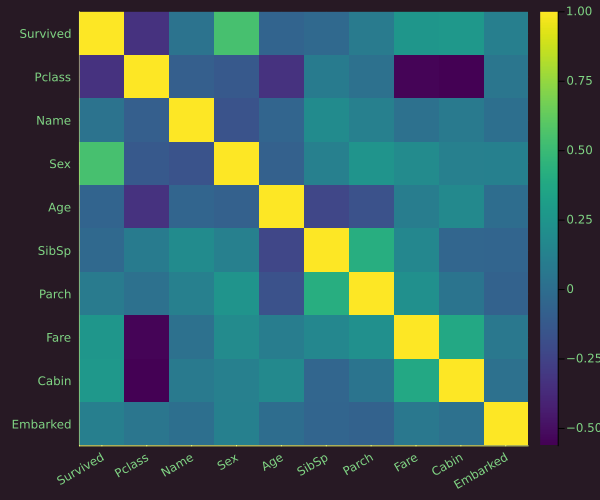

In [44]:
heatmap(cor(Matrix(df)); ticks=(1:length(names(df)), names(df)), xrotation=30, yflip=true)

### Standartize

In [ ]:
survived = df[!, :Survived]
df = standartize(df)
df.Survived = survived
df

## Splitting the dataset

In [45]:
trn, val, tst = random_split(df, [0.6, 0.2, 0.2])

3-element Vector{Any}:
 534×10 DataFrame
 Row │ Survived  Pclass  Name   Sex    Age      SibSp  Parch  Fare      Cabin  ⋯
     │ Int64     Int64   Int64  Int64  Float64  Int64  Int64  Float64   Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │        0       3      0      0     24.0      0      0    9.5         0  ⋯
   2 │        0       3      0      1     20.0      1      0    9.825       0
   3 │        0       3      0      0     28.0      0      0    7.7375      0
   4 │        0       3      0      0     22.0      0      0    7.25        0
   5 │        0       3      0      0     28.0      0      0    8.05        0  ⋯
   6 │        1       1      0      1     51.0      1      0   77.9583      4
   7 │        1       1      0      1     18.0      2      2  262.375       6
   8 │        0       2      0      0     39.0      0      0   13.0         0
  ⋮  │    ⋮        ⋮       ⋮      ⋮       ⋮       ⋮      ⋮       ⋮        ⋮    ⋱
 528 

## Models

### K-nn

In [81]:
survived = df[!, :Survived]
df_knn = standartize(df)
df_knn.Survived = survived
trn, val, tst = random_split(df_knn, [0.6, 0.2, 0.2])

3-element Vector{Any}:
 534×10 DataFrame
 Row │ Survived  Pclass     Name       Sex        Age        SibSp      Parch  ⋯
     │ Int64     Float64    Float64    Float64    Float64    Float64    Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │        0   0.826913  -0.259015  -0.737281  -0.411805  -0.474279  -0.473 ⋯
   2 │        0   0.826913  -0.259015   1.35481   -0.719032   0.43255   -0.473
   3 │        0   0.826913  -0.259015  -0.737281  -0.104579  -0.474279  -0.473
   4 │        0   0.826913  -0.259015  -0.737281  -0.565419  -0.474279  -0.473
   5 │        0   0.826913  -0.259015  -0.737281  -0.104579  -0.474279  -0.473 ⋯
   6 │        1  -1.56523   -0.259015   1.35481    1.66198    0.43255   -0.473
   7 │        1  -1.56523   -0.259015   1.35481   -0.872646   1.33938    2.007
   8 │        0  -0.369158  -0.259015  -0.737281   0.740295  -0.474279  -0.473
  ⋮  │    ⋮          ⋮          ⋮          ⋮          ⋮          ⋮          ⋮  ⋱

In [84]:
knn = K_nn(;n=5, metric=Titanic.l2)
model_fit!(knn, trn[!, [:Fare, :Sex]], trn[!, :Survived])
val_X, val_y = val[!, [:Fare, :Sex]], val[!, :Survived]
val_preds = model_predict(knn, val_X)
accuracy(val_y, val_preds)

0.7584269662921348

In [85]:
tst_X, tst_y = tst[!, [:Fare, :Sex]], tst[!, :Survived]
accuracy(model_predict(knn, tst_X), tst_y)

0.797752808988764

### Logistic regression

In [78]:
survived = df[!, :Survived]
df_lreg = standartize(df)
df_lreg.Survived = survived
trn, val, tst = random_split(df_lreg, [0.6, 0.2, 0.2])

3-element Vector{Any}:
 534×10 DataFrame
 Row │ Survived  Pclass     Name       Sex        Age        SibSp      Parch  ⋯
     │ Int64     Float64    Float64    Float64    Float64    Float64    Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │        0   0.826913  -0.259015  -0.737281  -0.411805  -0.474279  -0.473 ⋯
   2 │        0   0.826913  -0.259015   1.35481   -0.719032   0.43255   -0.473
   3 │        0   0.826913  -0.259015  -0.737281  -0.104579  -0.474279  -0.473
   4 │        0   0.826913  -0.259015  -0.737281  -0.565419  -0.474279  -0.473
   5 │        0   0.826913  -0.259015  -0.737281  -0.104579  -0.474279  -0.473 ⋯
   6 │        1  -1.56523   -0.259015   1.35481    1.66198    0.43255   -0.473
   7 │        1  -1.56523   -0.259015   1.35481   -0.872646   1.33938    2.007
   8 │        0  -0.369158  -0.259015  -0.737281   0.740295  -0.474279  -0.473
  ⋮  │    ⋮          ⋮          ⋮          ⋮          ⋮          ⋮          ⋮  ⋱

In [79]:
logreg = Log_reg()
trn_X, trn_y = trn[!, Not(:Survived)], trn[!, :Survived]
model_fit!(logreg, trn_X, trn_y)
val_X, val_y = val[!, Not(:Survived)], val[!, :Survived]
accuracy(model_predict(logreg, val_X), val_y)

0.797752808988764

In [80]:
tst_X, tst_y = tst[!, Not(:Survived)], tst[!, :Survived]
accuracy(model_predict(logreg, tst_X), tst_y)

0.7471910112359551

### NN

In [64]:
survived = df[!, :Survived]
df_nn = standartize(df)
df_nn.Survived = survived
trn, val, tst = random_split(df_nn, [0.6, 0.2, 0.2])

3-element Vector{Any}:
 534×10 DataFrame
 Row │ Survived  Pclass     Name       Sex        Age        SibSp      Parch  ⋯
     │ Int64     Float64    Float64    Float64    Float64    Float64    Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │        0   0.826913  -0.259015  -0.737281  -0.411805  -0.474279  -0.473 ⋯
   2 │        0   0.826913  -0.259015   1.35481   -0.719032   0.43255   -0.473
   3 │        0   0.826913  -0.259015  -0.737281  -0.104579  -0.474279  -0.473
   4 │        0   0.826913  -0.259015  -0.737281  -0.565419  -0.474279  -0.473
   5 │        0   0.826913  -0.259015  -0.737281  -0.104579  -0.474279  -0.473 ⋯
   6 │        1  -1.56523   -0.259015   1.35481    1.66198    0.43255   -0.473
   7 │        1  -1.56523   -0.259015   1.35481   -0.872646   1.33938    2.007
   8 │        0  -0.369158  -0.259015  -0.737281   0.740295  -0.474279  -0.473
  ⋮  │    ⋮          ⋮          ⋮          ⋮          ⋮          ⋮          ⋮  ⋱

In [70]:
trn_X, trn_y = trn[!, Not(:Survived)], trn[!, :Survived]
val_X, val_y = val[!, Not(:Survived)], val[!, :Survived]

args = Args(lr = 0.0005, batchsize=16, epochs=30, ratios=[0.8, 0.2])

m = Chain(Dense(length(names(trn_X)), 32, relu),
          Dense(32, 32, relu),
          Dense(32, 32, sigmoid),
          Dense(32, 32, relu),
          Dense(32, 32, sigmoid),
          Dense(32, 16, sigmoid),
          Dense(16, 8, relu),
          Dense(8, 2))
nn = Neural_network(;args = args, m=m)
model_fit!(nn, trn_X, trn_y, val_X, val_y; verbose = false)
accuracy(model_predict(nn, val_X), val_y)

0.8370786516853933

In [71]:
tst_X, tst_y = tst[!, Not(:Survived)], tst[!, :Survived]
accuracy(model_predict(nn, tst_X), tst_y)

0.8258426966292135

### Decision tree

In [58]:
df_dt = to_onehot(df, [:Name, :SibSp, :Parch, :Cabin]; remove_original=true)
trn, val, tst = random_split(df_dt, [0.6, 0.2, 0.2])

3-element Vector{Any}:
 534×32 DataFrame
 Row │ Survived  Pclass  Sex    Age      Fare      Embarked  Name_0  Name_1  N ⋯
     │ Int64     Int64   Int64  Float64  Float64   Int64     Int64   Int64   I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │        0       3      0     24.0    9.5            0       1       0    ⋯
   2 │        0       3      1     20.0    9.825          0       1       0
   3 │        0       3      0     28.0    7.7375         2       1       0
   4 │        0       3      0     22.0    7.25           0       1       0
   5 │        0       3      0     28.0    8.05           0       1       0    ⋯
   6 │        1       1      1     51.0   77.9583         0       1       0
   7 │        1       1      1     18.0  262.375          1       1       0
   8 │        0       2      0     39.0   13.0            0       1       0
  ⋮  │    ⋮        ⋮       ⋮       ⋮        ⋮         ⋮        ⋮       ⋮       ⋱
 528 │        0  

In [59]:
dt = Decision_tree(max_depth = 5; criterion=entropy_local)

Decision_tree(5, Titanic.entropy_local, nothing)

In [60]:
trn_X, trn_y = trn[!, Not(:Survived)], trn[!, :Survived]
model_fit!(dt, trn_X, trn_y)
val_X, val_y = val[!, Not(:Survived)], val[!, :Survived]
accuracy(model_predict(dt, val_X), val_y)

0.797752808988764

In [61]:
tst_X, tst_y = tst[!, Not(:Survived)], tst[!, :Survived]
accuracy(model_predict(dt, tst_X), tst_y)

0.8146067415730337